In [13]:
# ----- Initialisation ----
# import libraries required libraries
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [14]:
# load scrapped dataset
df = pd.read_csv("beckdel_allinfo_final.csv")
df.head()

,year,rating,imdbid,id,title,imdb_tt,genre,description,imdb_rating,bechdel_pass
0,1874,0,3155794,9602,Passage de Venus,tt3155794,"Documentary, Short, History",Early chronophotography of the 1874 Venus tran...,6.8,No
1,1877,0,14495706,9804,La Rosace Magique,tt14495706,"Animation, Short",Pre-cinematography color animation of Abstract...,5.7,No
2,1878,0,2221420,9603,Sallie Gardner at a Gallop,tt2221420,"Documentary, Short, Sport","The clip shows a jockey, Gilbert Domm, riding ...",7.3,No
3,1878,0,12592084,9806,Le singe musicien,tt12592084,"Animation, Short",Pre-cinematograph colour animation of the monk...,6.0,No
4,1881,0,7816420,9816,Athlete Swinging a Pick,tt7816420,"Documentary, Short","In this brief photographic sequence, Eadweard ...",5.1,No


In [15]:
# ---- Data Cleaning ----
df1 = df.drop(['imdbid','id','imdb_tt','description','title'],axis='columns')     #drop unwanted features
df2 = df1.dropna()     # drop null values

In [16]:
# ----------------------------------------------------------------------------
#     VISUALISATION DESIGN   : now we will be designing one visual at a time 
# ----------------------------------------------------------------------------

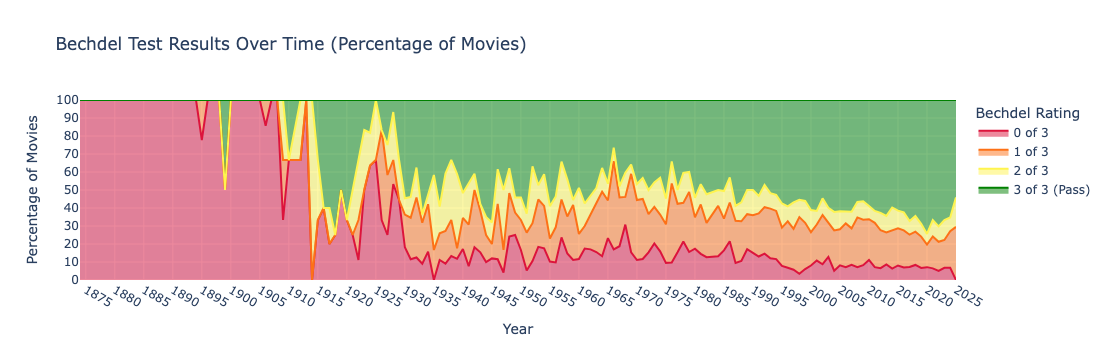

In [17]:
# ---- STACKED AREA CHART FOR BECHDEL TEST RESULTS OVER TIME ----

# ---- Data processing ----

# new copy of clean dataframe loaded into new variable for area chart
# this avoids modifying the original dataset used for other visuals
df_area = df2.copy()

# count how many movies fall into each bechdel rating category (0–3) for every year
grouped = (
    df_area.groupby(["year", "rating"])
    .size()
    .reset_index(name="count")
)

# convert raw counts into percentages within each year
grouped["percentage"] = grouped.groupby("year")["count"].transform(
    lambda x: 100 * x / x.sum()
)

# map numeric Bechdel scores to descriptive labels for readability in the legend
rating_labels = {
    0: "0 of 3",
    1: "1 of 3",
    2: "2 of 3",
    3: "3 of 3 (Pass)"
}

grouped["label"] = grouped["rating"].map(rating_labels)

# ---- Visualization ----

# create a stacked area chart showing how the proportion of each Bechdel category changes over time
fig = px.area(
    grouped.sort_values("label"),      # ensures consistent stacking order of categories
    x="year",
    y="percentage",
    color="label",
    color_discrete_sequence=px.colors.qualitative.Set1,
    title="Bechdel Test Results Over Time (Percentage of Movies)",
    labels={
        "year": "Year",
        "percentage": "Percentage of Movies",
        "label": "Bechdel Rating"
    },

    # define custom colour scheme
    color_discrete_map={
        "0 of 3": "#DC143C",           # red = fails all criteria
        "1 of 3": "#FD7117",           # orange = passes one criterion
        "2 of 3": "#FFF44F",           # yellow = passes two criteria
        "3 of 3 (Pass)": "#008000",    # green = passes all criteria
    }
)

# ---- Styling and interactivity ----
# lock the y-axis to a 0–100% range so the stacked areas always represent a full distribution
# and enable a unified hover mode to compare all categories at a given year
fig.update_layout(
    yaxis=dict(range=[0, 100]),
    hovermode="x unified"
)

# set consistent tick spacing
fig.update_xaxes(dtick=5)      # show year labels every 5 years
fig.update_yaxes(dtick=10)     # show percentage labels every 10%

# render the chart
fig.show()

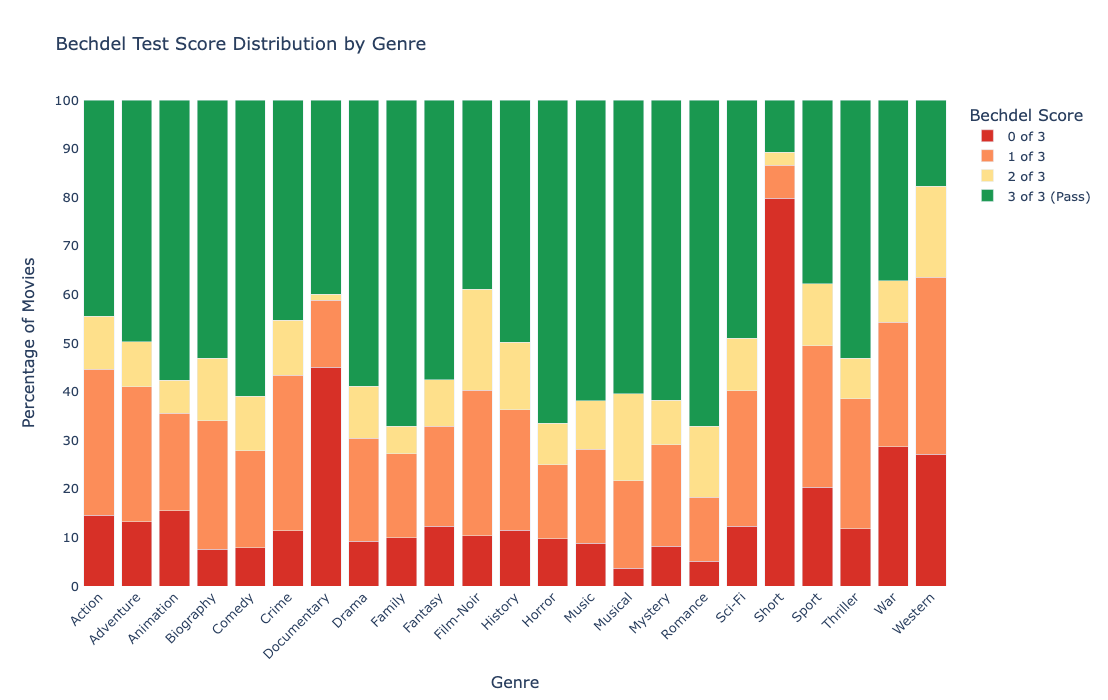

In [18]:
# ---- STACKED BAR CHART FOR BECHDEL TEST RESULTS BY GENRE ----

# ---- Data processing ----

# new copy of clean dataframe loaded into new variable
df_bar2 = df2.copy()

# split multi-genre entries into lists so each movie contributes to all its genres
df_bar2["genre_list"] = df_bar2["genre"].str.split(",")

# expand each list of genres into separate rows (one row per movie–genre pair)
df_bar2 = df_bar2.explode("genre_list") 

# clean up whitespace around genre names after splitting
df_bar2["genre_list"] = df_bar2["genre_list"].str.strip()

# keep only valid bechdel scores
df_bar2 = df_bar2[df_bar2["rating"].isin([0, 1, 2, 3])]

# remove genres with very few observations
df_bar2 = df_bar2[~df_bar2["genre_list"].isin(["Adult", "News"])]

# count how many movies fall into each Bechdel score for every genre
counts = (
    df_bar2.groupby(["genre_list", "rating"])
    .size()
    .reset_index(name="count")
)

# convert raw counts into percentages within each genre
counts["percentage"] = (
    counts.groupby("genre_list")["count"]
    .transform(lambda x: 100 * x / x.sum())
)

# map numeric Bechdel scores to descriptive labels for readability in the legend (same as previous plot)
rating_labels = {
    0: "0 of 3",
    1: "1 of 3",
    2: "2 of 3",
    3: "3 of 3 (Pass)"
}
counts["label"] = counts["rating"].map(rating_labels)

# ---- Sorting Logic ----

# order genres by percentage passing
pass_order = (
    counts[counts["rating"] == 3]
    .sort_values("percentage", ascending=False)["genre_list"]
)

# apply the custom genre order to the dataframe
counts["genre_list"] = pd.Categorical(
    counts["genre_list"],
    categories=pass_order,
    ordered=True
)

# ---- Visualisation ----

# create a stacked bar chart showing the distribution of Bechdel scores per genre
fig = px.bar(
    counts,
    x="genre_list",
    y="percentage",
    color="label",
    title=f"Bechdel Test Score Distribution by Genre",
    labels={
        "genre_list": "Genre",
        "percentage": "Percentage of Movies",
        "label": "Bechdel Score"
    },

    # ensure Bechdel score categories appear in logical order in the legend and stacks
    category_orders={
        "label": ["0 of 3", "1 of 3", "2 of 3", "3 of 3 (Pass)"]
    },

    # use a consistent red-to-green color scale to reflect failure and success
    color_discrete_map={
        "0 of 3": "#d73027",
        "1 of 3": "#fc8d59",
        "2 of 3": "#fee08b",
        "3 of 3 (Pass)": "#1a9850"
    }
)

# ---- Styling ----

# stack bars so each genre sums to 100%
fig.update_layout(
    barmode="stack",
    height=700,
    paper_bgcolor="white",
    plot_bgcolor="white",
    font=dict(size=13),
    xaxis_tickangle=-45     # rotate labels to improve readability
)

# lock y-axis to 0–100% for consistent visual comparison
fig.update_yaxes(range=[0, 100], dtick=10)

# render the chart
fig.show()

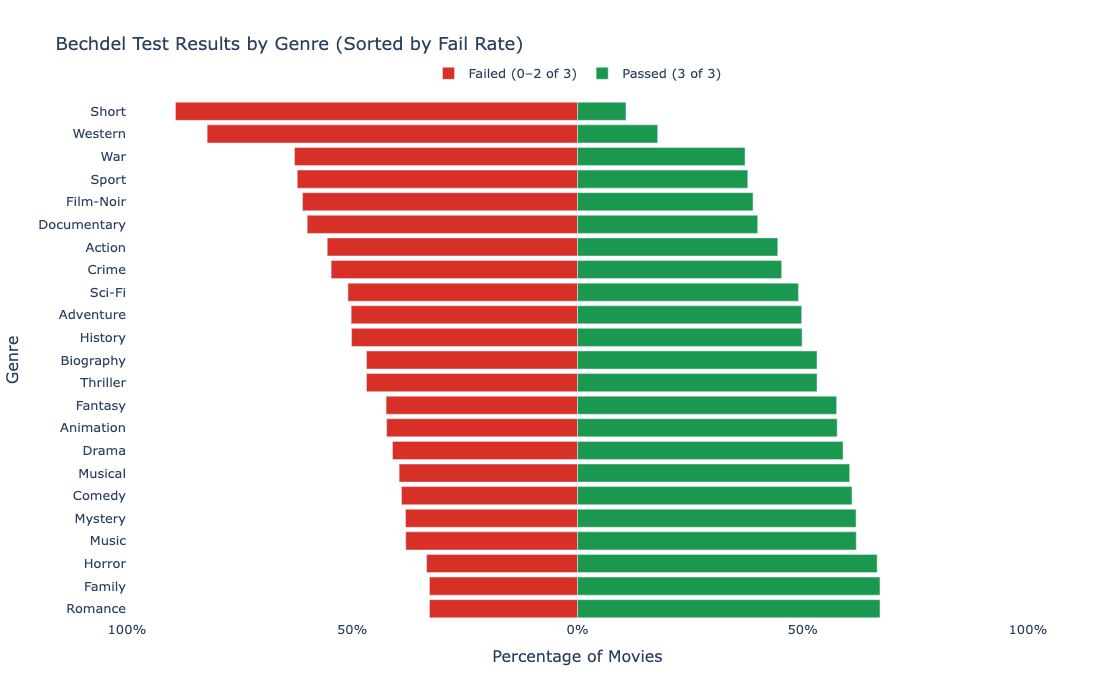

In [19]:
# ---- DIVERTING BAR CHART FOR BECHDEL TEST SCORE DISTRIBUTION PER GENRE ----

# new copy of clean dataframe loaded into new variable
df_bar = df2.copy()

# ---- Data Processing ----

# split multi-genre rows (same as previous plot)
df_bar["genre_list"] = df_bar["genre"].str.split(",")
df_bar = df_bar.explode("genre_list")
df_bar["genre_list"] = df_bar["genre_list"].str.strip()

# keep valid Bechdel ratings
df_bar = df_bar[df_bar["rating"].isin([0, 1, 2, 3])]

# remove genres with very few observations
df_bar = df_bar[~df_bar["genre_list"].isin(["Adult", "News"])]

# group by genre to calculate totals and pass/fail counts
grouped = df_bar.groupby("genre_list")

summary = grouped.agg(
    total=("rating", "count"),      # Total number of movies in each genre
    pass_count=("rating", lambda x: (x == 3).sum()),       # Number of movies that pass the test (3 of 3)
    fail_count=("rating", lambda x: (x != 3).sum())        # Number of movies that partially pass the test (1/2 of 3)
).reset_index()

# convert raw counts into percentages for fair comparison across genres
summary["pass_pct"] = 100 * summary["pass_count"] / summary["total"]
summary["fail_pct"] = 100 * summary["fail_count"] / summary["total"]

# sort genres by ascending fail rate
summary = summary.sort_values("fail_pct", ascending=True)

# ---- Visualisation ----

# creat a diverging bar chart
fig = go.Figure()

# add FAIL bars (plotted as negative values so they extend left)
fig.add_bar(
    y=summary["genre_list"],
    x=-summary["fail_pct"],
    orientation="h",
    name="Failed (0–2 of 3)",
    marker_color="#d73027",       # red = failure
    hovertemplate="Genre: %{y}<br>Fail: %{x:.1f}%<extra></extra>"
)

# add PASS bars (plotted as positive values so they extend right)
fig.add_bar(
    y=summary["genre_list"],
    x=summary["pass_pct"],
    orientation="h",
    name="Passed (3 of 3)",
    marker_color="#1a9850",       # green = success
    hovertemplate="Genre: %{y}<br>Pass: %{x:.1f}%<extra></extra>"
)

# ---- Styling ----

# allows left/right stacking from the center
fig.update_layout(
    title="Bechdel Test Results by Genre (Sorted by Fail Rate)",
    barmode="relative",
    height=700,
    paper_bgcolor="white",
    plot_bgcolor="white",
    xaxis_title="Percentage of Movies",
    yaxis_title="Genre",
    font=dict(size=13),
    legend=dict(orientation="h", y=1.08, x=0.5, xanchor="center")
)

# create centered percentage axis
fig.update_xaxes(
    tickvals=[-100, -50, 0, 50, 100],
    ticktext=["100%", "50%", "0%", "50%", "100%"],
    range=[-100, 100]
)

# render the figure
fig.show()

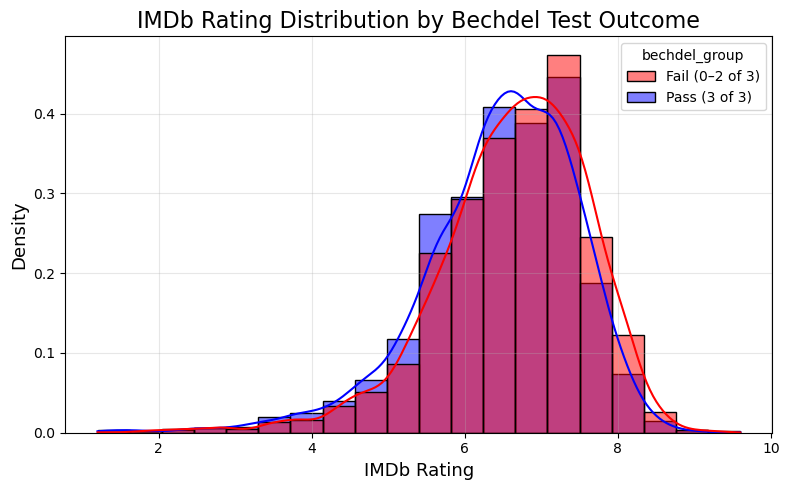

In [20]:
# ---- HISTOGRAM FOR IMDB RATING DISTRIBUTION BY BECHDEL TEST ----

# new copy of clean dataframe loaded into new variable
df_histo = df2.copy()

# ---- Data Processing ----

#create a binary grouping variable for Bechdel outcome
df_histo["bechdel_group"] = df_histo["rating"].apply(
    lambda x: "Pass (3 of 3)" if int(round(x)) == 3 else "Fail (0–2 of 3)"
)

# ---- Visulaisation ----

# initialize figure with a wide aspect ratio for clear distribution comparison
plt.figure(figsize=(8, 5))

# plot overlapping histograms with KDE curves
sns.histplot(
    data=df_histo,
    x="imdb_rating",
    hue="bechdel_group",       # split distributions by Bechdel outcome
    bins=20,
    stat="density",
    common_norm=False,
    kde=True,                  # overlay smooth density curves for trend comparison
    palette={
        "Pass (3 of 3)": "#0000FF",   # blue = films that pass the test
        "Fail (0–2 of 3)": "#FF0000"  # red = films that fail the test
    },
    alpha=0.5        # transparency for better overlap visibility
)

# ---- Styling ----

plt.title("IMDb Rating Distribution by Bechdel Test Outcome", fontsize=16)
plt.xlabel("IMDb Rating", fontsize=13)
plt.ylabel("Density", fontsize=13)

plt.grid(alpha=0.3)      # light grid
plt.tight_layout()

# render the plot
plt.show()

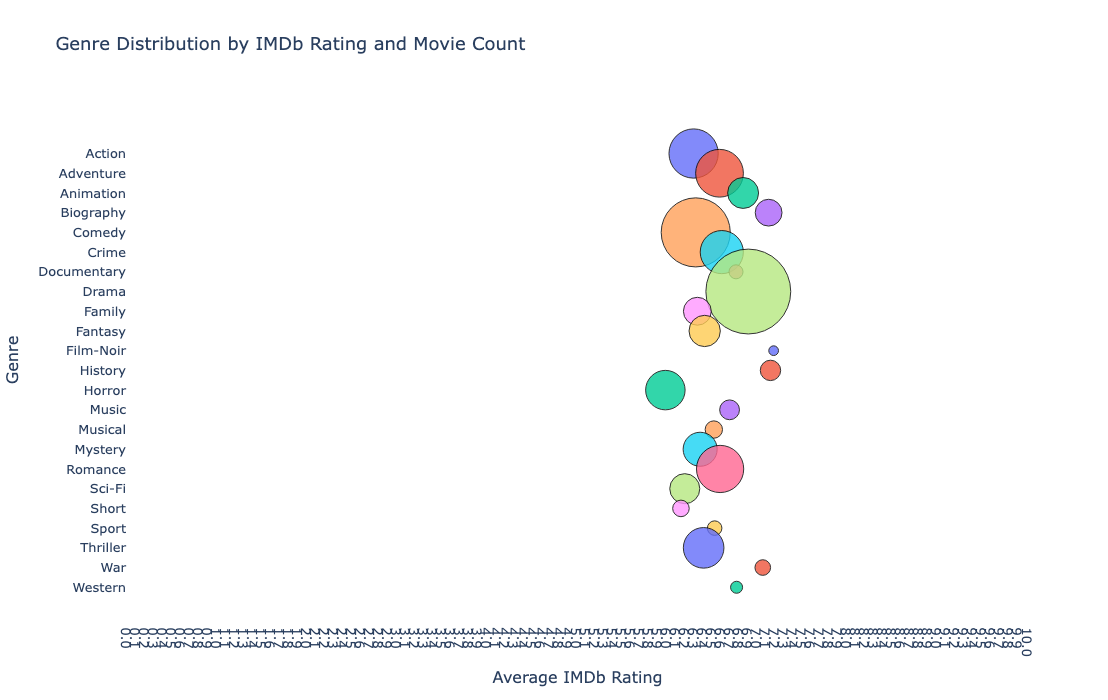

In [21]:
# ---- BUBBLE CHART FOR GENRE DISTRIBUTION BY IMDB RATING AND MOVIE COUNT ----

# new copy of clean dataframe loaded into new variable
df_bubble2= df2.copy()

# ---- Data Processing ----

# split multi-genre rows
df_bubble2["genre"] = df_bubble2["genre"].str.split(",")
df_bubble2 = df_bubble2.explode("genre")
df_bubble2["genre"] = df_bubble2["genre"].str.strip()

# calculate how many movies fall inot each genre and their avg imdb rating
genre_stats = (
    df_bubble2.groupby("genre")
    .agg(
        count=("imdb_rating", "size"),
        avg_rating=("imdb_rating", "mean")
    )
    .reset_index()
)

# remove genres with very few movies
genre_stats = genre_stats[genre_stats["count"] >= 5]

# add horizontal jitter for readablity
np.random.seed(42)
genre_stats["x_jitter"] = genre_stats["avg_rating"] + np.random.uniform(
    -0.15, 0.15, len(genre_stats)
)

# ---- Visualisation ----

# create bubble plot
fig = px.scatter(
    genre_stats,
    x="x_jitter",
    y="genre",
    size="count",
    color="genre",   # assigns a unique color to each genre
    size_max=60,
    title="Genre Distribution by IMDb Rating and Movie Count",
    labels={
        "x_jitter": "Average IMDb Rating",
        "genre": "Genre",
        "count": "Number of Movies"
    },
    hover_data={
        "avg_rating": ":.2f",
        "count": True,
        "genre": True
    }
)

# ---- Styling ----

fig.update_layout(
    height=700,
    paper_bgcolor="white",
    plot_bgcolor="white",
    font=dict(size=13),
    showlegend=False  # hide legend if too cluttered (many genres)
)

# standard scale across full 0-10 range 
fig.update_xaxes(
    range=[0, 10],
    dtick=0.1,          # shows fine tick spacing like 6.1, 6.2, 6.3, etc.
    tickformat=".1f"   # force one decimal place
)

# improve bubble visibility and separation
fig.update_traces(marker=dict(opacity=0.8, line=dict(width=1, color="black")))

# render the chart
fig.show()

# autoscale the graph after running to get clearest visual

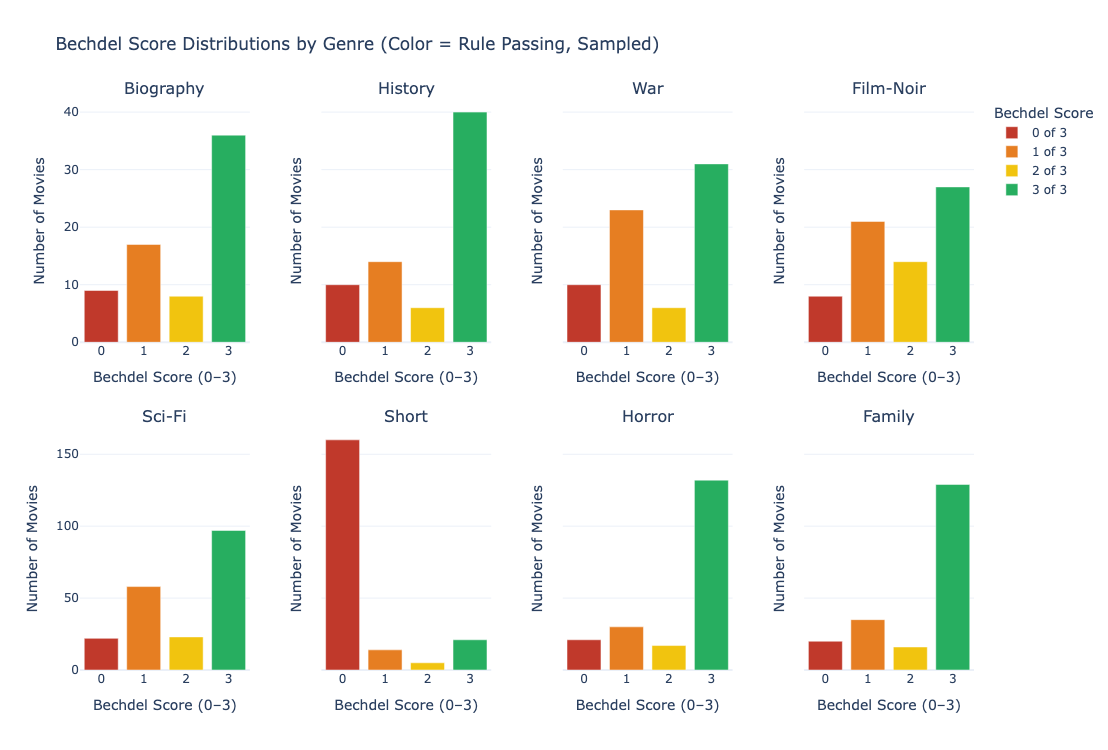

In [22]:
# ---- MINI BAR CHART GRID FOR BECHDEL SCORE DISTRIBUTIONS BY SELECTED GENRES ----

# ---- Configuration ----

# initialising
RIGHT_GENRES = ["Biography", "History", "War", "Film-Noir"]   # Genres with higher average IMDb ratings
LEFT_GENRES = ["Sci-Fi", "Short", "Horror", "Family"]         # Genres with lower average IMDb ratings
ALL_GENRES = RIGHT_GENRES + LEFT_GENRES       # Combined list for subplot layout

# sample sizes per genre
# smaller, consistent samples for high-rated niche genres
# larger samples for high-volume genres to preserve distribution shape
SAMPLE_MAP = {
    "Biography": 70,
    "History": 70,
    "War": 70,
    "Film-Noir": 70,
    "Sci-Fi": 200,
    "Short": 200,
    "Horror": 200,
    "Family": 200
}

# valid Bechdel score categories
SCORES = [0, 1, 2, 3]

# bechdel color scheme
SCORE_COLORS = {
    0: "#C0392B",  # red
    1: "#E67E22",  # orange
    2: "#F1C40F",  # yellow
    3: "#27AE60"   # green
}

# ---- data processing ----

# new copy of clean dataframe loaded into new variable
df = df2.copy()

df["bechdel_score"] = pd.to_numeric(df["rating"], errors="coerce")

# split multi-genre movies
df["genre"] = df["genre"].str.split(", ")
df = df.explode("genre")

# keep only genres of interest for the comparison grid
df = df[df["genre"].isin(ALL_GENRES)]

# subplot layout
fig = make_subplots(
    rows=2,
    cols=4,
    subplot_titles=ALL_GENRES,
    shared_yaxes=True,
    horizontal_spacing=0.08,
    vertical_spacing=0.15
)

# building mini charts
for i, genre in enumerate(ALL_GENRES):
    r = 1 if i < 4 else 2
    c = i + 1 if i < 4 else i - 3

    gdata = df[df["genre"] == genre]

    # randomly sample a fixed number of movies per genre
    # this normalizes comparisons between high-volume and niche genres
    n_sample = SAMPLE_MAP[genre]
    if len(gdata) > n_sample:
        gdata = gdata.sample(n_sample, random_state=42)

    # count movies in each Bechdel score category
    counts = (
        gdata["bechdel_score"]
        .value_counts()
        .reindex(SCORES, fill_value=0)
        .sort_index()
    )

    # add one bar per score so each can be color-coded individually
    for score in SCORES:
        fig.add_trace(
            go.Bar(
                x=[score],
                y=[counts.loc[score]],
                marker_color=SCORE_COLORS[score],
                showlegend=(i == 0),
                name=f"{score} of 3"
            ),
            row=r,
            col=c
        )

# ---- Styling ----

fig.update_layout(
    title="Bechdel Score Distributions by Genre (Color = Rule Passing, Sampled)",
    template="plotly_white",
    height=750,
    legend_title_text="Bechdel Score"
)

# standardize X-axis across all subplots
fig.update_xaxes(
    title_text="Bechdel Score (0–3)",
    tickmode="array",
    tickvals=SCORES
)

# shared Y-axis label for clarity
fig.update_yaxes(
    title_text="Number of Movies"
)

# render the figure
fig.show()


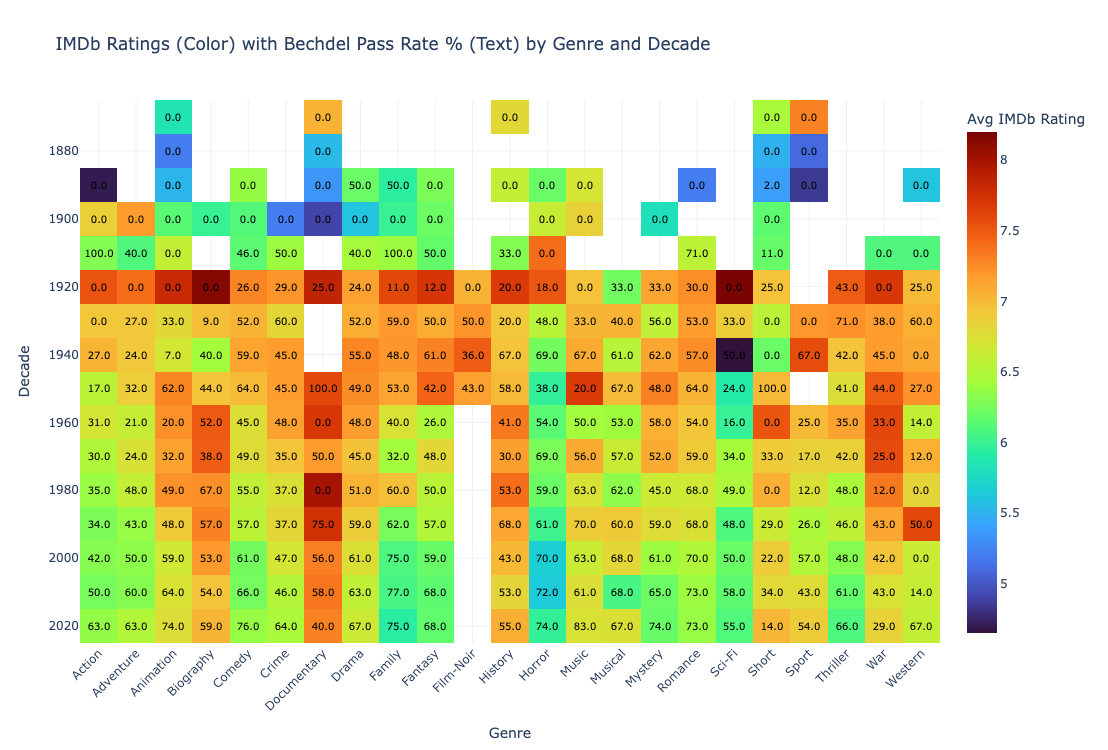

In [23]:
# ---- HEAT MAP FOR IMDB RATINGS AND BECHDEL PASS RATES BY GENRE AND DECADE ----

# new copy of clean dataframe loaded into new variable
df = df2.copy()

# ---- Data Processing ----

# split multi-genre entries
df["genre"] = df["genre"].str.split(", ")
df = df.explode("genre")

# group movies into decades
df["decade"] = (df["year"] // 10) * 10

# remove genres with very few movies
MIN_MOVIES = 50
valid_genres = df["genre"].value_counts()
valid_genres = valid_genres[valid_genres >= MIN_MOVIES].index
df = df[df["genre"].isin(valid_genres)]

# aggregate metrics
summary = (
    df.groupby(["decade", "genre"])
      .agg(
          avg_rating=("imdb_rating", "mean"),
          pass_rate=("bechdel_pass", lambda x: (x == "Yes").mean() * 100),
          count=("imdb_rating", "count")
      )
      .reset_index()
)

# create matrix for heat map
rating_pivot = summary.pivot(
    index="decade",
    columns="genre",
    values="avg_rating"
)

# create a matching matrix for Bechdel pass rates
pass_text = summary.pivot(
    index="decade",
    columns="genre",
    values="pass_rate"
).round(0)

# clean nan values in heatmap
Z_clean = rating_pivot.copy().astype(float)
Z_clean[np.isnan(Z_clean)] = None
T_clean = pass_text.copy()
T_clean = np.where(np.isnan(T_clean), "", T_clean)

# ---- Visualisation ----

# build heatmap
fig = px.imshow(
    Z_clean,
    aspect="auto",
    color_continuous_scale="Turbo",
    labels=dict(
        x="Genre",
        y="Decade",
        color="Avg IMDb Rating"
    ),
    title="IMDb Ratings (Color) with Bechdel Pass Rate % (Text) by Genre and Decade"
)

# overlay Bechdel pass rate as text inside each cell
fig.update_traces(
    text=T_clean.astype(str) + "",
    texttemplate="%{text}",
    textfont=dict(color="black", size=10)
)

# ---- styling ----

fig.update_layout(
    template="plotly_white",
    height=750,
    xaxis_tickangle=-45
)

# render the figure
fig.show()

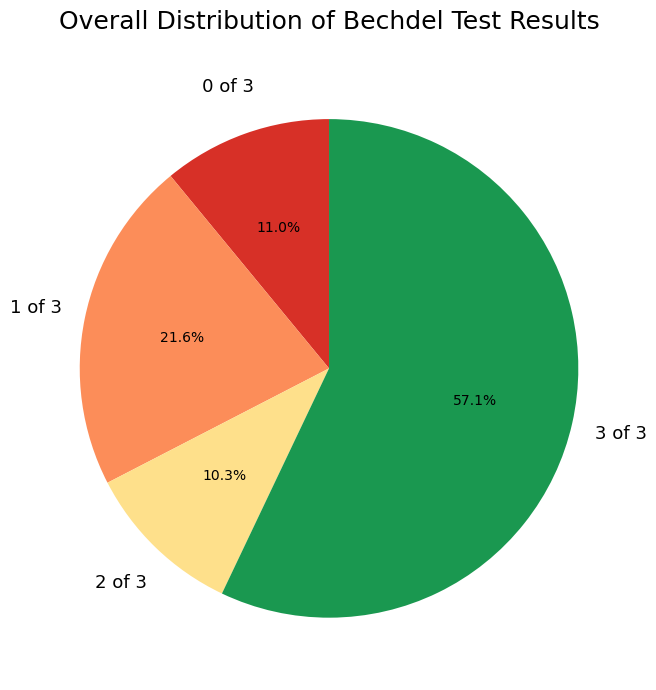

In [24]:
# ---- PIE CHART FOR OVERALL DISTRIBUTION OF BECHDEL TEST RESULTS ----

# new copy of clean dataframe loaded into new variable
df_matplotpie = df2.copy()

# ---- Data Processing ----

# count movies by rating
counts = df_matplotpie["rating"].value_counts().sort_index()

labels = [
    "0 of 3",
    "1 of 3",
    "2 of 3",
    "3 of 3"
]

values = [counts.get(i, 0) for i in range(4)]

# colors (red , orange , yellow , green)
colors = ["#d73027", "#fc8d59", "#fee08b", "#1a9850"]

# ---- Visualisation ----

# create pie chart
fig, ax = plt.subplots(figsize=(7, 7))

wedges, texts, autotexts = ax.pie(
    values,
    colors=colors,
    startangle=90,
    autopct="%1.1f%%",
    pctdistance=0.6,
    textprops=dict(color="black", fontsize=10),
    wedgeprops=dict(linewidth=0)
)

# add labels outside
for i, wedge in enumerate(wedges):
    
    # calculate the angle of each slice
    angle = (wedge.theta1 + wedge.theta2) / 2

    # convert polar coordinates to Cartesian for label placement
    x = np.cos(np.deg2rad(angle))
    y = np.sin(np.deg2rad(angle))

    # annotate each slice with its corresponding label
    ax.annotate(
        labels[i],
        xy=(0.9 * x, 0.9 * y),      # point on pie edge
        xytext=(1.2 * x, 1.2 * y),  # label position
        ha="center",
        va="center",
        fontsize=13,
        color="black"
    )

# ---- styling ----

ax.set_title(
    "Overall Distribution of Bechdel Test Results",
    fontsize=18,
    color="black",
    pad=20
)

ax.set_aspect("equal")   # ensure the pie is perfectly circular
plt.tight_layout()
plt.show()  # display the chart